# Forecast Ice Cream Production

*Pranav Shah*

## Introduction

In this exercise, we'll examine monthly ice cream production from 1995 to 2014. First we'll examine if it is stationary or not, then decompose it into components, and finally make forecasts. 

## Summary

Here are a few take aways from analysis: 

- The ice cream production time series is stationary. The analysis with the ACF, PCF, and time series plots show stationarity as does the ADF test. 
- There is a significant seasonal component to the ice cream time series. Plotting the time series, viewing the ACF plot, and decompsing the time series provides evidence of significant seasonality. 
- The best fit ARMA model for the decomposing the time series's remainder is ARIMA(3,0,1). 
- Additionally, confidence intervals do increase over time and the intervals seem reasonable given the forecasts. 

## Get Data

First, load and view the structure of the dairy csv data. Then we'll capture just the ice cream production data. Next, the ice cream production data frame is converted to a time series. 

In [3]:
# Get Data
file <- "CADairyProduction.csv"
dairy <- read.csv(file, header = TRUE, stringsAsFactors = FALSE)
str(dairy)

'data.frame':	228 obs. of  9 variables:
 $ Year             : int  1995 1995 1995 1995 1995 1995 1995 1995 1995 1995 ...
 $ Month            : chr  "Jan" "Feb" "Mar" "Apr" ...
 $ Cotagecheese.Prod: num  4.37 3.69 4.54 4.28 4.47 ...
 $ Icecream.Prod    : num  51.6 56.1 68.5 65.7 73.7 ...
 $ Milk.Prod        : num  2.11 1.93 2.16 2.13 2.23 ...
 $ N.CA.Fat.Price   : num  0.98 0.892 0.892 0.897 0.897 ...
 $ Month.Count      : int  1 2 3 4 5 6 7 8 9 10 ...
 $ monthNumSqred    : int  1 4 9 16 25 36 49 64 81 100 ...
 $ monthNumCubed    : int  1 8 27 64 125 216 343 512 729 1000 ...


In [4]:
# Get Ice Cream Data
IceCream <- dairy[,c("Year", "Month", "Icecream.Prod")]

head(IceCream)

Year,Month,Icecream.Prod
1995,Jan,51.595
1995,Feb,56.086
1995,Mar,68.453
1995,Apr,65.722
1995,May,73.730
1995,Jun,77.994


In [5]:
# Convert to a time series
IceCream.ts <- ts(IceCream[,3], start = IceCream[1,1], frequency = 12)

head(IceCream.ts)

[1] 51.595 56.086 68.453 65.722 73.730 77.994

## Evaluate Stationarity

In order to analyze a time series and make forecasts, we need to determine if the time series is stationary. A stationary time series means that the mean and variance over the span of the time series is constant. Typically time series that exhibit a random walk - where the data point exhibits a cumulative sum of the previous points' white noise - and a strong sustained trend are not stationary. 

We can examine auto/partial correlation plots and test the time series in a hypothesis test to determine if the time series stationary. 

### Plot series

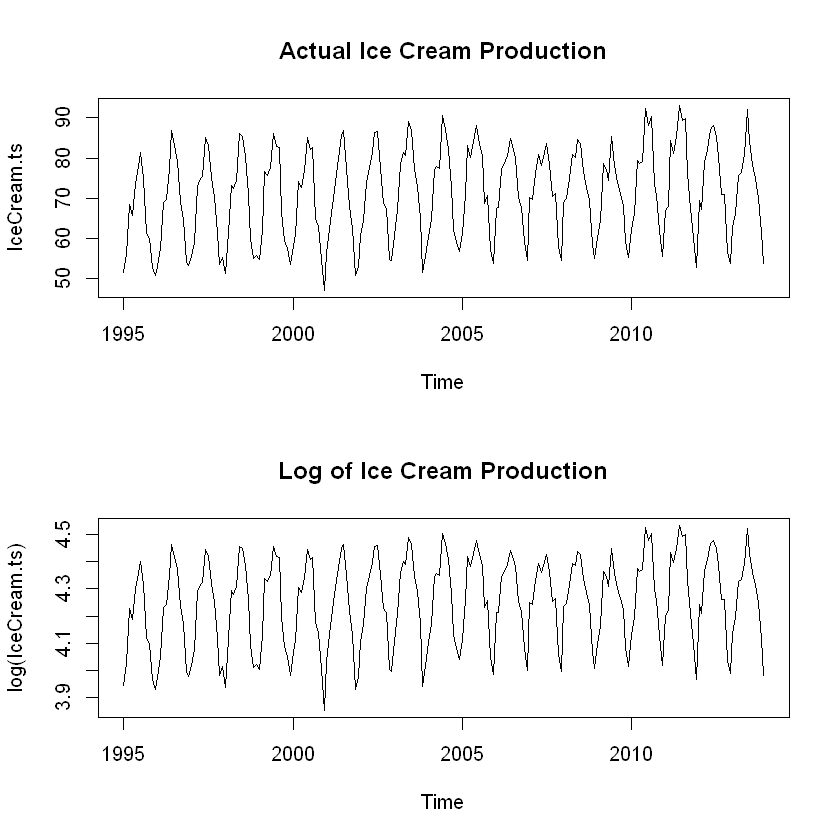

In [6]:
# Plot the time series both actuals and log transformed

par(mfrow = c(2,1))
plot(IceCream.ts, main = "Actual Ice Cream Production")
plot(log(IceCream.ts), main = "Log of Ice Cream Production")
par(mfrow = c(1,1))

From the above plots we can see a strong cyclical pattern within the year. Ice cream production spikes mid-way through the year during the summer time, which intuitively makes sense. This indicates a strong seasonal component in the time series. Additionally there is a slight upward trend, but not strong. The seasonal spikes don't seem to be growing over time, which could indicate a change in variance and thus non-stationary. If the seasonal spikes grow over time we might say that the time series is multiplicative, and taking the log of the production could correct for this. Since there doesn't seem to be a growth in the spikes (note no change in shape of time series/spikes when taking the log), we will continue the analysis with a non-transformed production value. 

### Distribution plots

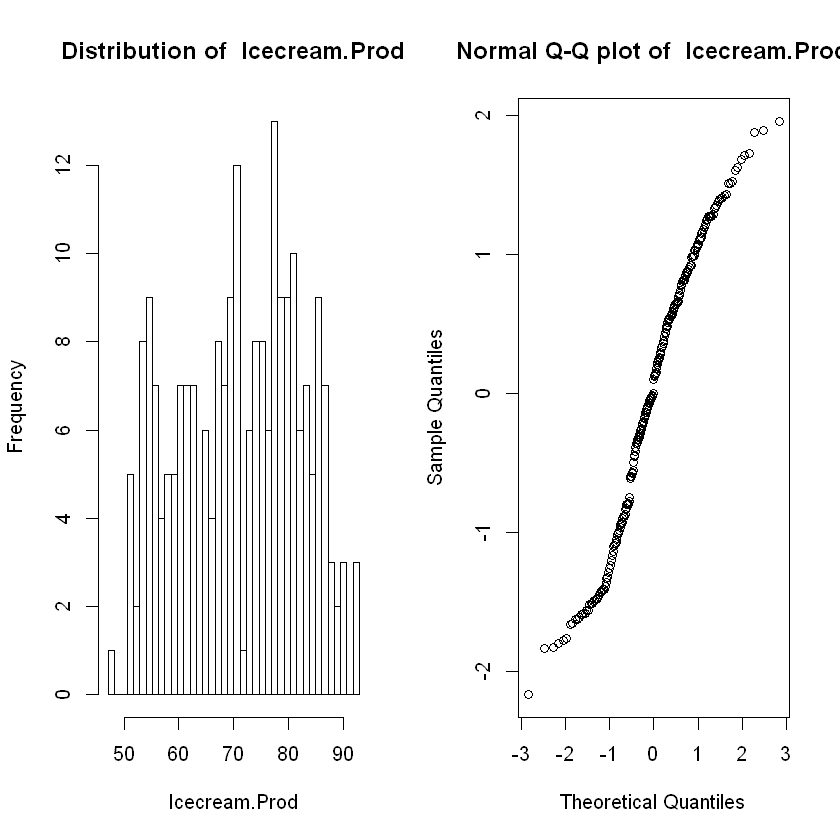

In [8]:
# are the values normally distributed? If normally distributed then independently identically distributed

dist.ts = function(df, col = 'residual', bins = 40){
  par(mfrow = c(1,2))
  temp = as.vector(df)
  breaks = seq(min(temp), max(temp), length.out = (bins + 1))
  hist(temp, breaks = breaks, main = paste('Distribution of ', col), xlab = col)
  qqnorm(scale(temp), main = paste('Normal Q-Q plot of ', col))
  par(mfrow = c(1,1))
}

dist.ts(IceCream.ts, col = "Icecream.Prod")

A time series is said to be independently identically distributed if the values in the trend are normally distributed, which means the time series is white noise. This is not the case for our ice cream time series. While visually close, both the histogram and QQ plot point to a time series that isn't normally distributed and thus not just white noise. 

### ACF and PCF

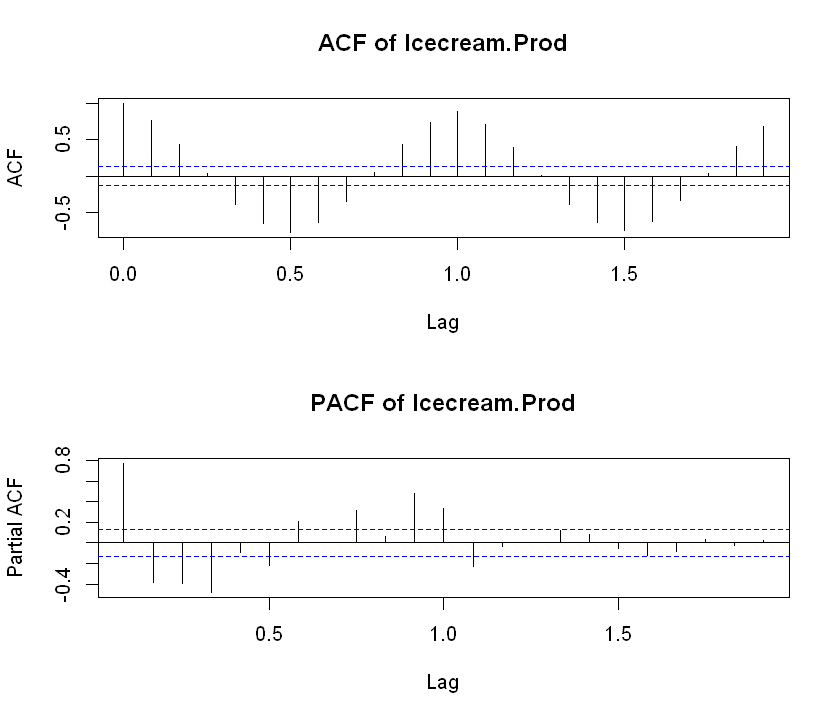

In [9]:
options(repr.pmales.extlot.width=8, repr.plot.height=6)
plot.acf <- function(df, col = 'remainder', is.df =TRUE){
  if(is.df) temp <- df[, col]
  else temp <- df
  par(mfrow = c(2,1))
  acf(temp, main = paste('ACF of', col))
  pacf(temp, main = paste('PACF of', col))
  par(mfrow = c(1,1))
}

plot.acf(IceCream.ts, col ="Icecream.Prod", is.df = FALSE)

The ACF and PCF shows significant autocorrelations and partial correlations at lags. From the ACF we see many significant lags in a cyclical pattern, but we don't see a slow decay which would be evidence of a random walk or strong trend. Again, if we see a random walk or strong trend from the ACF, this would point to a non-stationary time series. Additionally, the PCF has several significant PCFs. Because we have significant lags in both the ACF(exclude 0) and PCF this series isn't white noise. 

### Augmented Dickey-Fuller

A numerical method to test for stationarity is the ADF test. The null hypothesis is that the series tested is not stationary. When running the test on our time series, we see that there is a significant p-value to reject the null hypothesis, meaning that our time series is stationary.

In [7]:
# Use the ADF test to test stationarity
require(tseries)
adf.test(IceCream.ts, alternative = "stationary")

Loading required package: tseries
Warning message in adf.test(IceCream.ts, alternative = "stationary"):
"p-value smaller than printed p-value"


	Augmented Dickey-Fuller Test

data:  IceCream.ts
Dickey-Fuller = -10.376, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary


## STL Decomposition

Here we will decompose the time series into the seasonal, trend, and residual components. 

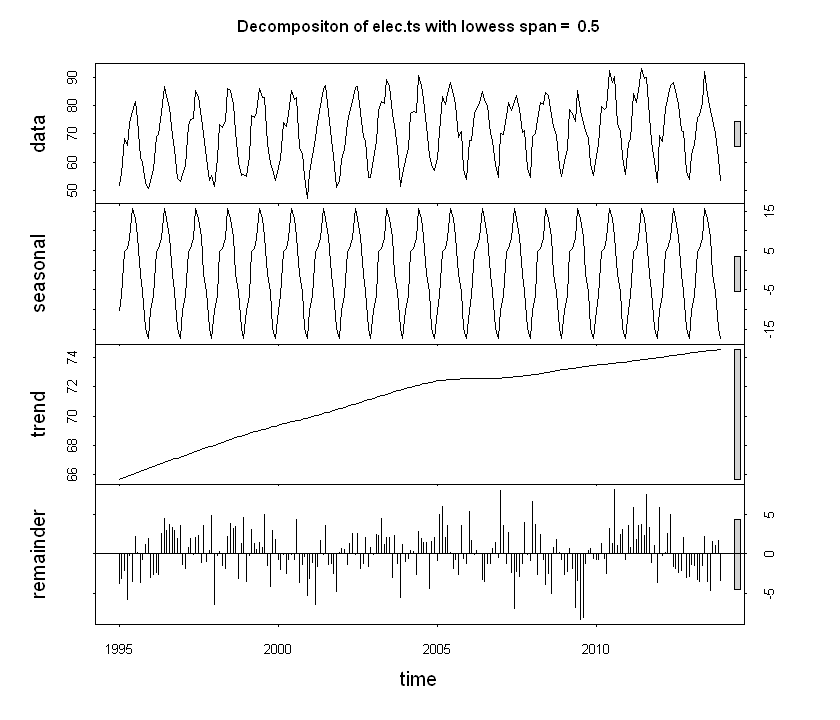

In [10]:
# decompose time series into seasonal, trend, and remainder

ts.decomp <- function(df, col = 'elec.ts', span = 0.5, Mult = TRUE, is.df = TRUE){
  # if(Mult) temp = log(df[, col])  else temp = ts(df[, col]
  if(is.df) temp = log(df[, col])  
  else temp = df
  spans = span * length(temp)  
  fit <- stl(temp, s.window = "periodic", t.window = spans)
  plot(fit, main = paste('Decompositon of',col,'with lowess span = ', as.character(span)))
  fit$time.series
}

IceCream.decomp <- ts.decomp(IceCream.ts, is.df = FALSE, Mult = FALSE)


From the decomposition plot visuallizes nicely a few of the previous statements mentioned from other plots. We see that there is a strong seasonal component and a slight positive trend. There is a remainder that visually looks like white noise, which if were the case means we've captured most everything we can in the signal in the other components. Plotting an ACF and PCF on the remainder can help determine if this is the case.

### ACF and PCF on STL remainder 

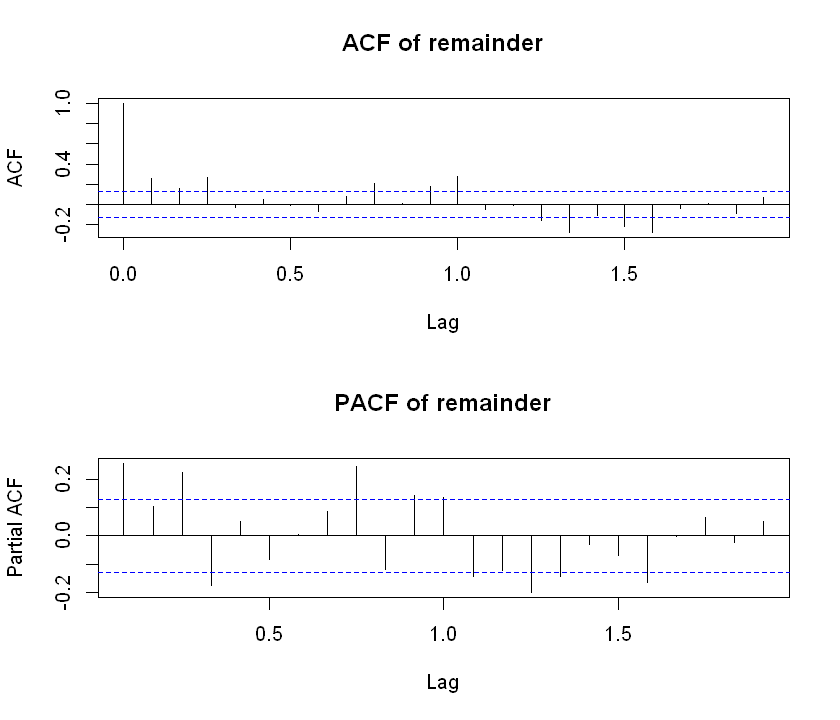

In [11]:
# Does remainder reflect white noise? Use acf to see if there are significant lags
plot.acf(IceCream.decomp[,3], col = "remainder", is.df = FALSE)

In the ACF plot of the remainder component of the time series we see significant lags besides 0. The PCF has several significant lags. Because of this we can say that the reamainder is not white noise. We can take an ARMA on the remainder to find out what best fits the remainder component.

### ARMA on remainder

We can run an ARMA model on the remainder decomposed component of the ice cream time series to figure out what best fits/explains the data. Judging from the PCF above there are several lags that are significant, which points to an auto regressive component of 3-5. The ACF shows a few significant lags, which points to moving average component of maybe 1 or 2. We can run an  ARMA model to test these ranges. Note: we tested other ranges as well to be sure, and then verified with an auto-arima.


Call:
arima(x = ts, order = order, include.mean = FALSE)

Coefficients:
          ar1     ar2     ar3     ma1
      -0.4617  0.2082  0.2890  0.7385
s.e.   0.1182  0.0759  0.0671  0.1135

sigma^2 estimated as 7.15:  log likelihood = -548.02,  aic = 1106.04


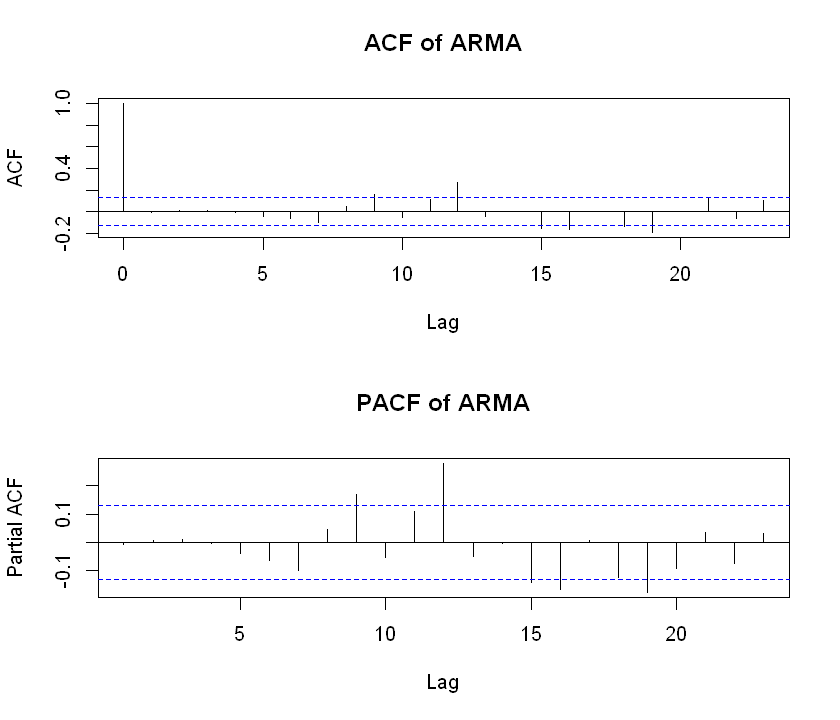

In [19]:
# ARIMA model
ts.model = function(ts, col = 'remainder', order = c(0,0,1)){
  mod = arima(ts, order = order, include.mean = FALSE)
  print(mod)
  mod
}

mod.est <- ts.model(IceCream.decomp[,3], col = 'ARMA', order = c(3,0,1))
plot.acf(mod.est$resid[-1], col = 'ARMA', is.df = F)

After trying several combinations we arrived at an ARMA model of (3,0,1) that exhibited the lowest AIC and best standard error proportions on the coeffiecents. The ACF and PCF get much closer to white noise (there are a few stray significant lags in both). We can confirm what we arrived at manually with the auto.arima function.

Series: IceCream.decomp[, 3] 
ARIMA(4,0,1) with zero mean     

Coefficients:
          ar1     ar2     ar3     ar4     ma1
      -0.4904  0.2104  0.2950  0.0233  0.7636
s.e.   0.1520  0.0757  0.0714  0.0903  0.1355

sigma^2 estimated as 7.308:  log likelihood=-547.99
AIC=1107.97   AICc=1108.35   BIC=1128.55

Training set error measures:
                     ME     RMSE      MAE      MPE     MAPE      MASE
Training set 0.02366338 2.673589 2.155859 75.61771 161.1021 0.7982701
                     ACF1
Training set 0.0006731984


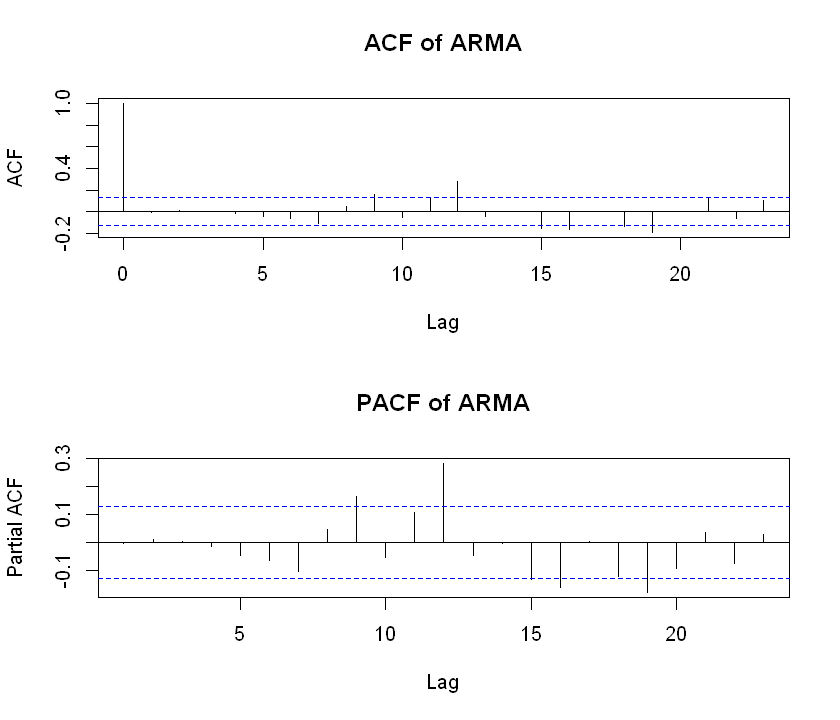

In [20]:
# Confirm with auto.arima
mod.est <- auto.arima(IceCream.decomp[,3], max.d = 0, seasonal = FALSE)
summary(mod.est)
plot.acf(mod.est$resid[-1], col = 'ARMA', is.df = F)

The auto.arima function on the remainder component shows a best fit model (4,0,1) that is slightly different from the one we arrived at manually. One thing to note is that the AIC is actually a bit higher that the fourth auto regressive term has a large standard error. The ACF and PCF don't seem significantly different. Since both are close, I would say either show to fit the remainder.

## Forecast with auto.arima

Next we'll use the auto.arima function the find the best arima model for our ice cream time series. We will set the parameters such that we allow seasonality and drift. 

Series: IceCream.ts 
ARIMA(4,0,1)(0,1,2)[12] with drift         

Coefficients:
          ar1     ar2     ar3     ar4     ma1     sma1     sma2   drift
      -0.6703  0.2777  0.3759  0.1641  0.9305  -0.5005  -0.2550  0.0379
s.e.   0.0876  0.0773  0.0777  0.0770  0.0548   0.0725   0.0683  0.0112

sigma^2 estimated as 7.63:  log likelihood=-526.93
AIC=1071.87   AICc=1072.74   BIC=1102.25

Training set error measures:
                     ME     RMSE      MAE        MPE     MAPE      MASE
Training set 0.08607263 2.638315 2.017612 0.04295444 2.845819 0.7309931
                   ACF1
Training set 0.00999941


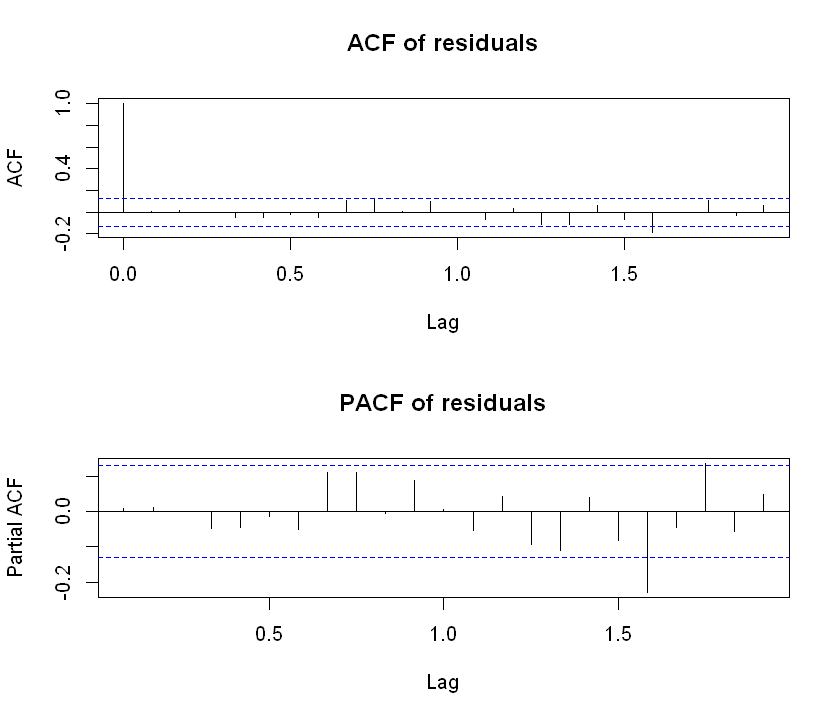

In [22]:
# ARIMA and plot acf residuals

require(forecast)
IceCream.ARIMA <- auto.arima(IceCream.ts, max.p=4, max.q=4,
                             max.P=2, max.Q=2, max.order=5, max.d=2, max.D=1,
                             start.p=0, start.q=0, start.P=0, start.Q=0)
summary(IceCream.ARIMA)

plot.acf(IceCream.ARIMA$residuals, col = "residuals", is.df = FALSE)


The auto.arima function returns a best fit model that has a seasonal component and drift (4,0,1)(0,1,2).The coefficients seem to be at least a magnitude larger than the standard errors, with the exception of drift. Additionally, the ACF and PCF of the residual seems to exhibit white noise behavior (no significant lags, except at 0 for ACF).

### Forecast 12 months out

When we use the model obtained can now be used to forecast out. First we forecast 12 months out. The predicted production starts at 64 in Jan 14 and peaks to 92 in Jun 14 before falling back to 56 in Dec 14. 


Forecast method: ARIMA(4,0,1)(0,1,2)[12] with drift

Model Information:
Series: IceCream.ts 
ARIMA(4,0,1)(0,1,2)[12] with drift         

Coefficients:
          ar1     ar2     ar3     ar4     ma1     sma1     sma2   drift
      -0.6703  0.2777  0.3759  0.1641  0.9305  -0.5005  -0.2550  0.0379
s.e.   0.0876  0.0773  0.0777  0.0770  0.0548   0.0725   0.0683  0.0112

sigma^2 estimated as 7.63:  log likelihood=-526.93
AIC=1071.87   AICc=1072.74   BIC=1102.25

Error measures:
                     ME     RMSE      MAE        MPE     MAPE      MASE
Training set 0.08607263 2.638315 2.017612 0.04295444 2.845819 0.7309931
                   ACF1
Training set 0.00999941

Forecasts:
         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jan 2014       64.00784 60.46765 67.54803 58.59359 69.42210
Feb 2014       68.82175 65.16363 72.47987 63.22713 74.41637
Mar 2014       77.87455 74.19823 81.55088 72.25210 83.49701
Apr 2014       79.62275 75.70930 83.53620 73.63764 85.60785
May 2014       81

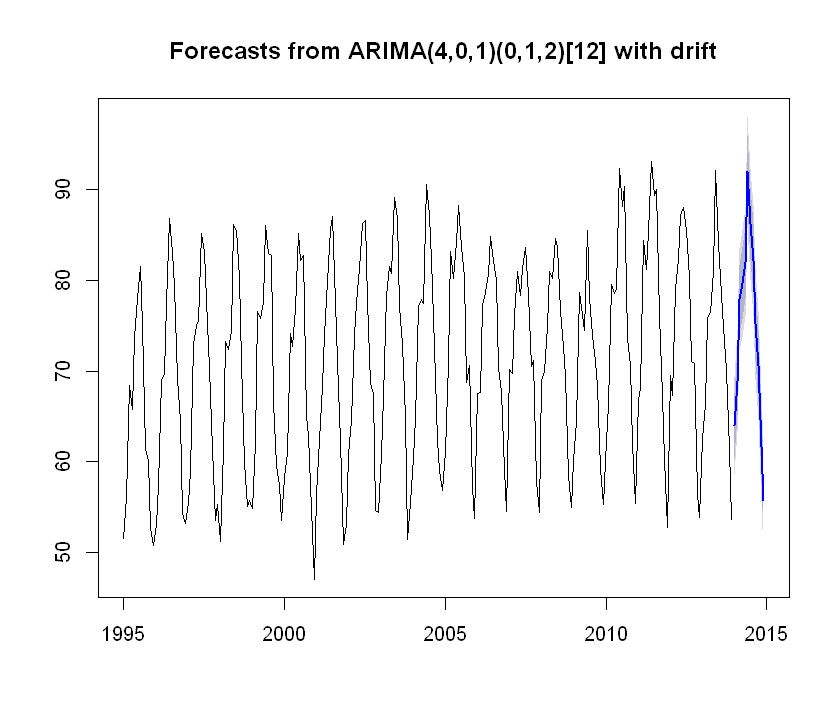

In [13]:
# Forecast 12 months ahead and plot
IceCream.forecast <- forecast(IceCream.ARIMA, h = 12)
summary(IceCream.forecast)

plot(IceCream.forecast)

The 95% confidence range seems to increase as time increases, but it is hard to determine this definitively from the plot we have. Zooming into the range may help. 

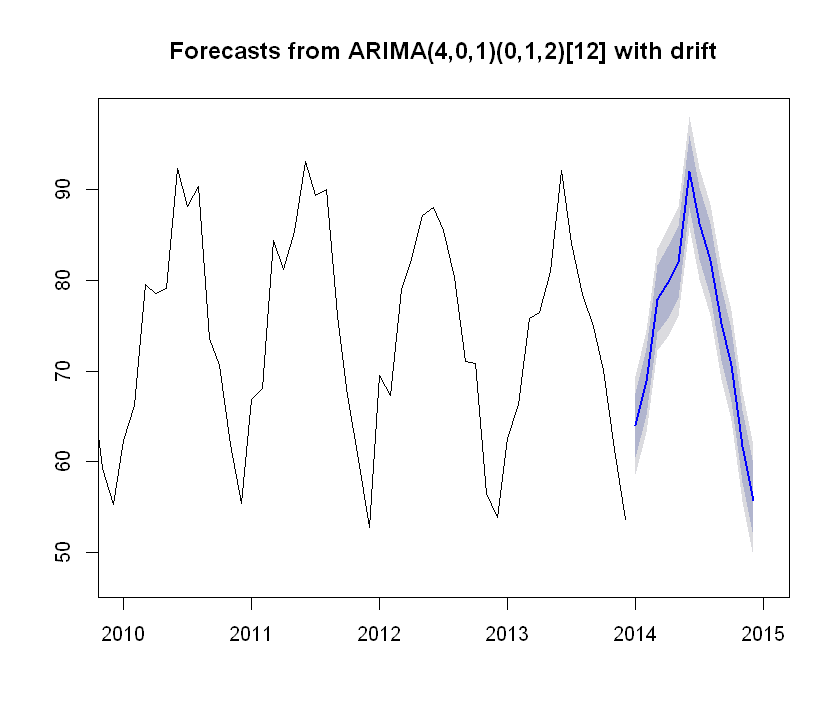

In [14]:
# Zoom into confidence intervals
plot(IceCream.forecast, xlim = c(2010, 2015))

Zooming in provides a better view. The light grey range around the mean forecast represents the 95% confidence range of the forecast. It does seem to increase as time increases, which intuitively makes sense since the uncertaintity of most predictions increases with time. Forecasting 36 months out helps to visually see the expanding confidence ranges.

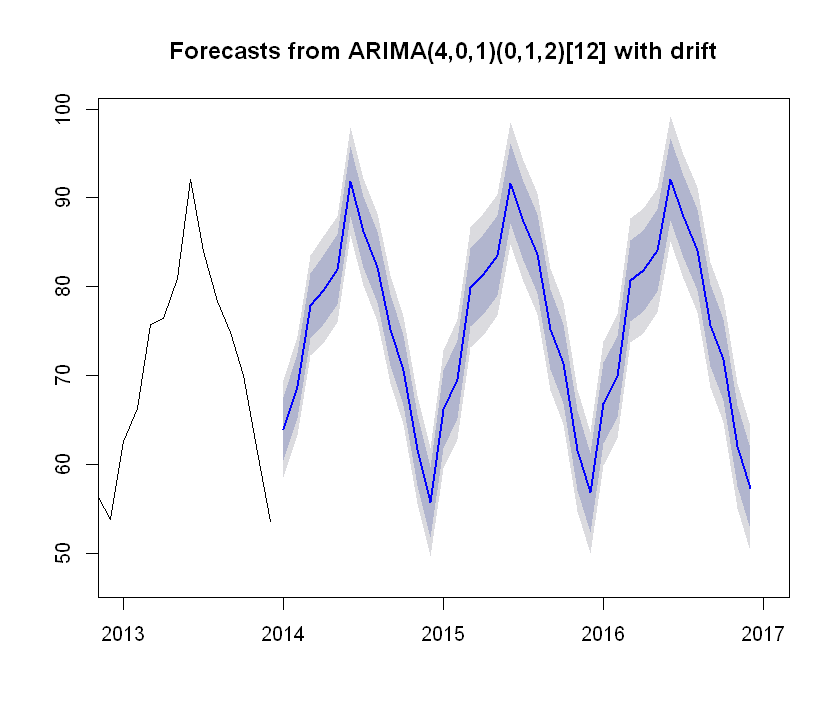

In [18]:
# Forecast 36 months ahead and plot
IceCream.forecast <- forecast(IceCream.ARIMA, h = 36)
plot(IceCream.forecast, xlim = c(2013, 2017))

Plotting the 95% confidence interval size with time can also better see these increases. The range grows year to year and within the first few months of a year but plateaus in latter half of the year. The range also increases month over month (Jan 15 vs Jan 14). These ranges also seem resonable given the mean forecast for the month given the magnitude of the forecast.

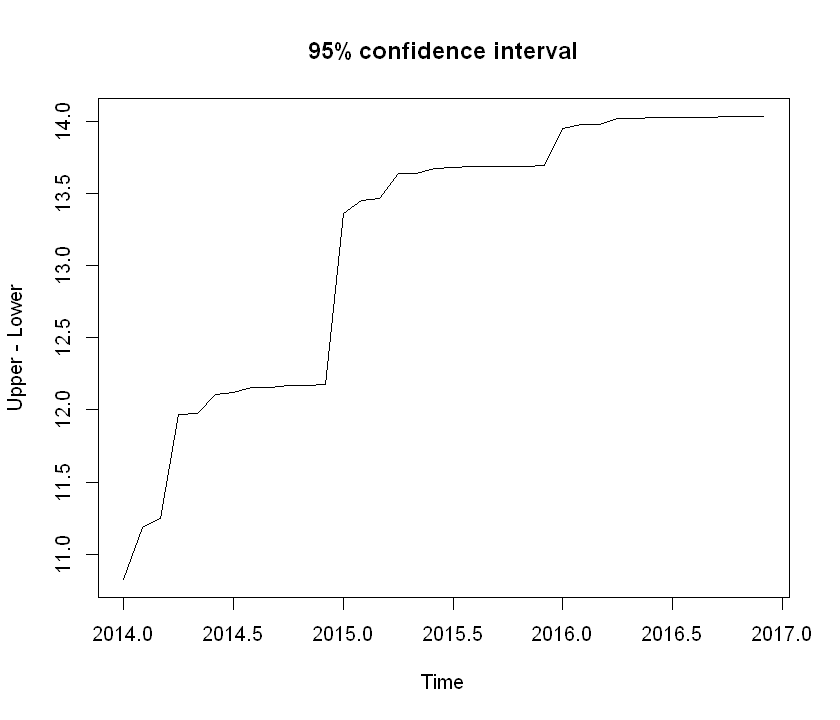

In [23]:
# plot 95% confidence interval range vs. time

range.95 <- IceCream.forecast$upper[,2]-IceCream.forecast$lower[,2]
plot(range.95, main = "95% confidence interval", ylab = "Upper - Lower")